In [1]:
import numpy as np
import xarray as xr
from modules.ADI import ADI
from modules.classes import Quantity2D, Analytic, Interpolate
from modules.tests import plot_mass_conservation, calculate_boundary_flux, integrate_concentration
from modules.functions import animate
import matplotlib.pyplot as plt
from modules.tests import test_gaussian
import xarray as xr

In [2]:
# Initialize a constant diffusion coefficient function
'''
diffusion = Analytic(lambda x, y: y**2)
diffusion.set_partial_x(lambda x, y: y)
diffusion.set_partial_y(lambda x, y: x)
'''


'\ndiffusion = Analytic(lambda x, y: y**2)\ndiffusion.set_partial_x(lambda x, y: y)\ndiffusion.set_partial_y(lambda x, y: x)\n'

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>)

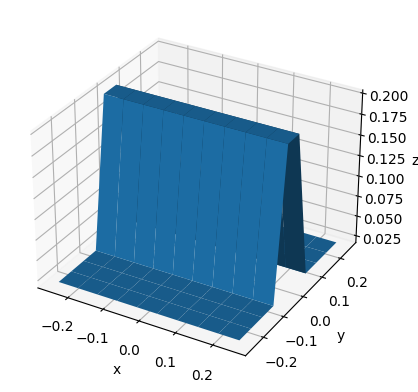

In [3]:
n_grid = 100
n_time = 500
dt = 0.0001
dx = 0.005
dy = 0.005
conc = Quantity2D(
    n_grid,
    n_time,
    (-0.5*n_grid*dx, 0.5*n_grid*dx),
    (-0.5*n_grid*dy, 0.5*n_grid*dy),
    (0, dt*n_time),
)

diffarr = 0.02*np.ones((10, 10))
diffarr[:,4:-4] = 0.2 # Vary along x; partial_x should be constant
xint = np.linspace(-0.5*n_grid*dx, 0.5*n_grid*dx, 10)
yint = np.linspace(-0.5*n_grid*dy, 0.5*n_grid*dy, 10)
diffusion = Interpolate(diffarr, xint, yint, s=0)

diffusion.plot_2D(func='func')

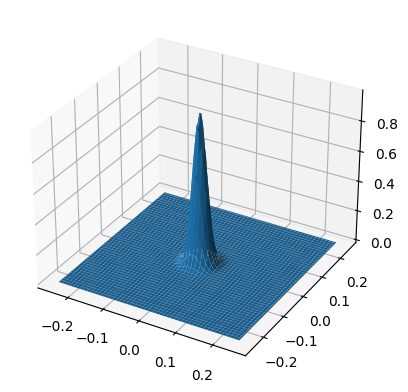

In [4]:
xcoords = conc.xcoords
ycoords = conc.ycoords
X, Y = np.meshgrid(xcoords, ycoords)
initial_condition = 1*np.exp(- (X**2 + Y**2)/(0.05*dx*n_grid)**2)
sources =  1*np.exp(- (X**2 + Y**2)/(0.05*dx*n_grid)**2)
#initial_condition = np.empty_like(X)
#initial_condition[n_grid//2, n_grid//2] = 100

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, sources)

In [5]:
result_ds = ADI(conc, diffusion, initial_condition, sources, BC='dirichlet')
# Issue with explicit component vectors blowing up to infinity/nan values

KeyboardInterrupt: 

In [ ]:
result_ds

<xarray.Dataset> Size: 40MB
Dimensions:        (x: 100, y: 100, t: 500)
Coordinates:
  * x              (x) float64 800B -0.25 -0.2449 -0.2399 ... 0.2399 0.2449 0.25
  * y              (y) float64 800B -0.25 -0.2449 -0.2399 ... 0.2399 0.2449 0.25
  * t              (t) float64 4kB 0.0 0.0001002 0.0002004 ... 0.0499 0.05
Data variables:
    concentration  (x, y, t) float64 40MB 1.384e-87 0.0 0.0 0.0 ... 0.0 0.0 0.0
    diffusion      (x, y) float64 80kB 0.02 0.0176 0.01589 ... 0.0176 0.02
    sources        (x, y) float64 80kB 1.384e-87 7.553e-86 ... 1.384e-87
Attributes:
    dx:        0.005050505050505051
    dy:        0.005050505050505051
    dt:        0.0001002004008016032
    n_grid:    100
    n_time:    500
    metadata:  Generated by crank_nicholson_1D

In [ ]:
result_ds.to_netcdf('test_file.nc')

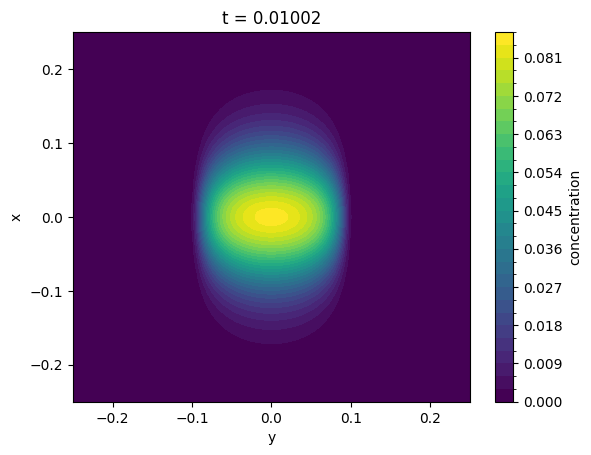

In [ ]:
xr.plot.contourf(result_ds['concentration'].isel(t=100), levels=30)

In [ ]:
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

def animate(ds, vmin=None, vmax=None, cmap='RdBu_r', levels=30):
    if not vmax:
        vmax = ds['concentration'].max()
        vmin = -vmax

    n_time = ds.attrs['n_time']
    fig, ax = plt.subplots()
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')
    x = ds.coords['x']
    y = ds.coords['y']
    tcoords = ds.coords['t'].values
    z = ds['concentration'].values
    conc = ax.contourf(x, y, z[:,:,0], cmap=cmap, levels=levels)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    def animate(t):
        ax.clear()
        #cax.cla()
        ax.set_title("time = %.3g" % tcoords[t])
        conc = ax.contourf(x, y, z[:,:,t], cmap=cmap, levels=levels)
        #cbar = fig.colorbar(conc)
        #conc.set_array(z[:,:,t])
        return conc,
    anim = animation.FuncAnimation(fig, animate, frames = n_time, interval=1, repeat=True, blit=False)
    writergif = animation.PillowWriter(fps=20)
    return anim, writergif

In [ ]:
'''
anim, writergif = animate(result_ds, levels=100)
anim.save(r'test.gif',writer=writergif)
plt.show()
'''

"\nanim, writergif = animate(result_ds, levels=100)\nanim.save(r'test.gif',writer=writergif)\nplt.show()\n"

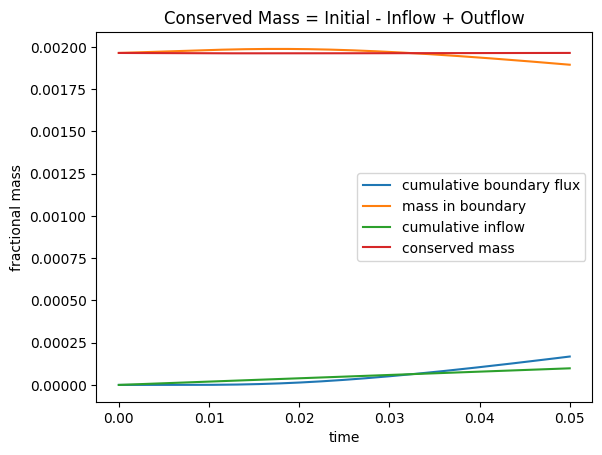

In [ ]:
fig, ax = plot_mass_conservation(result_ds)

In [2]:
test_int, test_analytic = test_gaussian(ADI, BC='dirichlet')
diff = test_int - test_analytic

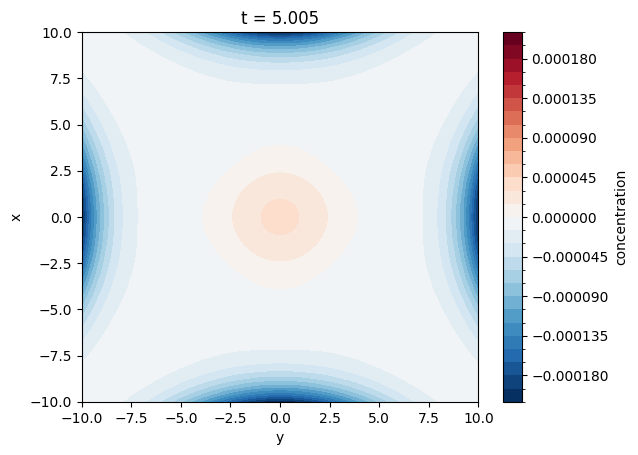

In [8]:
xr.plot.contourf(diff.isel(t=100), levels=30)

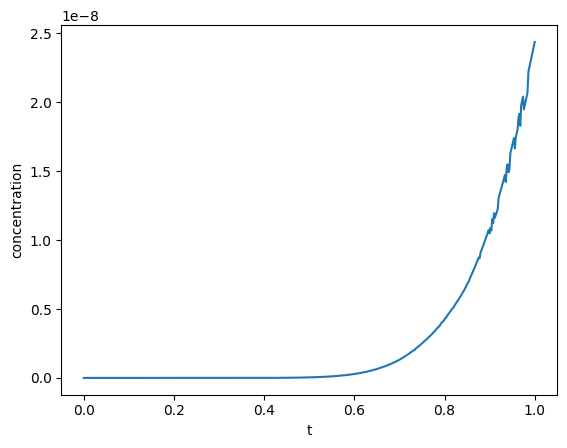

In [19]:
absdiff = np.absolute(diff)
absdiff.median(dim=('x','y')).plot()

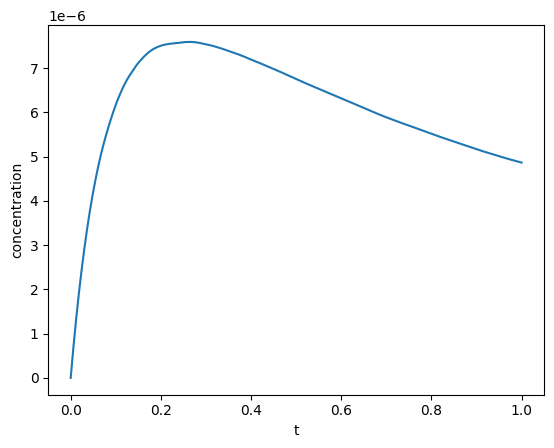

In [20]:
absdiff.mean(dim=('x','y')).plot()